In [3]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Linux-5.15.133+-x86_64-with-glibc2.31
PyTorch Version: 2.1.2

Python 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
Pandas 2.2.0
Scikit-Learn 1.2.2
NVIDIA/CUDA GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


In [4]:
!pip install opencv-python-headless

In [5]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms
import cv2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn 
import torch.optim as optim 

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import binary_opening, disk, label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

train_data = os.listdir('/kaggle/input/airbus-ship-detection/train_v2')
test_data = os.listdir('/kaggle/input/airbus-ship-detection/test_v2')


image_path_train = '/kaggle/input/airbus-ship-detection/train_v2'
image_path_test = '/kaggle/input/airbus-ship-detection/test_v2'

In [8]:
submission = pd.read_csv('/kaggle/input/airbus-ship-detection/sample_submission_v2.csv')
submission

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2
...,...,...
15601,ffdb3cda6.jpg,1 2
15602,ffe3857eb.jpg,1 2
15603,ffeb765e8.jpg,1 2
15604,ffeba1475.jpg,1 2


In [9]:
mask = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
display(mask.head(5))
print((mask.shape))

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


(231723, 2)


Empty images without ships:  150000
Images containing ships:  81723


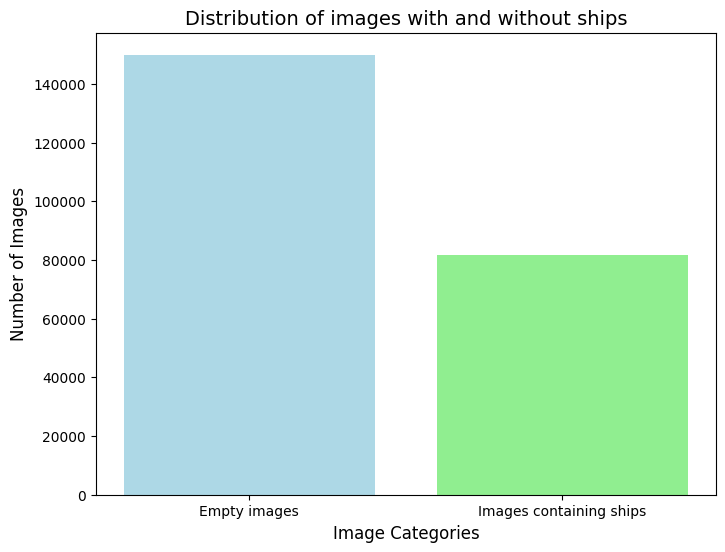

In [10]:
empty_ship = mask['EncodedPixels'].isna().sum()
print('Empty images without ships: ', empty_ship)

Containing_ship = mask['EncodedPixels'].notna().sum()
print('Images containing ships: ', Containing_ship)

# Визуализация
import matplotlib.pyplot as plt

# Список категорий
categories = ['Empty images', 'Images containing ships']
counts = [empty_ship, Containing_ship]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['lightblue', 'lightgreen'])
plt.title('Distribution of images with and without ships', fontsize=14)
plt.xlabel('Image Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

In [11]:
df = mask.groupby('ImageId').agg({'EncodedPixels': 'count'})
df = df.rename(columns={'EncodedPixels' : 'ships'})
df['has_ship'] = df['ships'].map(lambda x: 1 if x > 0 else 0)
df

,ships,has_ship
ImageId,,
00003e153.jpg,0,0
0001124c7.jpg,0,0
000155de5.jpg,1,1
000194a2d.jpg,5,1
0001b1832.jpg,0,0
...,...,...
fffedbb6b.jpg,0,0
ffff2aa57.jpg,0,0
ffff6e525.jpg,0,0


In [12]:
df_without_ship = mask[mask['EncodedPixels'].notna()]
df_without_ship

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
231694,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...
231713,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...


In [13]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):#тут побитовое или. типа была картинка с 1-ками для первого корабля и 0 для фона, а на второй картинке этот же корабль 0, 
    #а второй корабль уже единичка и когда побитовое или единичка выигрывает
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [15]:
import pandas as pd
import numpy as np

def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def combine_masks(mask_list):
    combined_mask = None
    for mask_rle in mask_list:
        if isinstance(mask_rle, str):
            mask = rle_decode(mask_rle)
            if combined_mask is None:
                combined_mask = mask
            else:
                combined_mask |= mask  # Используем операцию ИЛИ (OR) для объединения масок
    return combined_mask


# 
# Группируем данные по названию изображения и объединяем маски для каждой группы
combined_masks = df_without_ship.groupby('ImageId')['EncodedPixels'].apply(lambda x: combine_masks(x.tolist()))


In [16]:
mask['ships'] = mask['EncodedPixels'].map(lambda x: 1 if not pd.isna(x) else 0)
mask

,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [17]:
df = mask.groupby('ImageId').agg({'EncodedPixels': 'count'})
df = df.rename(columns={'EncodedPixels' : 'ships'})
df['has_ship'] = df['ships'].map(lambda x: 1 if x > 0 else 0)
df

,ships,has_ship
ImageId,,
00003e153.jpg,0,0
0001124c7.jpg,0,0
000155de5.jpg,1,1
000194a2d.jpg,5,1
0001b1832.jpg,0,0
...,...,...
fffedbb6b.jpg,0,0
ffff2aa57.jpg,0,0
ffff6e525.jpg,0,0


In [18]:
counts = df['ships'].value_counts()
counts.reset_index()
counts


ships
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

In [19]:
combined_masks

ImageId
000155de5.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
000194a2d.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
00021ddc3.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
0002756f7.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
00031f145.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                                       ...                        
fff77c602.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fff909871.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fffcb6464.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fffd924fb.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fffdd2377.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: EncodedPixels, Length: 42556, dtype: object

In [20]:
df_combined_masks = pd.DataFrame(combined_masks)
df_combined_masks

,EncodedPixels
ImageId,
000155de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
000194a2d.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00021ddc3.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0002756f7.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00031f145.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...
fff77c602.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
fff909871.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
fffcb6464.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [21]:
df_10000 = df_combined_masks.sample(10000)
df_10000.reset_index(inplace = True)

In [22]:
df_10000

,ImageId,EncodedPixels
0,eb9504faf.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,03b25bda9.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,b9643a242.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,e99925018.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,3c18d42cd.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
9995,6efe6b665.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9996,ce3a56c41.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9997,7f6dec1ba.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9998,0b26b2861.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
# folder_with_mask =  os.listdir('D:/загрузки/mask_as_image_1000')
# folder_with_image = os.listdir('D:/загрузки/train_v2')
# image_path = 'D:/загрузки/train_v2'
# mask_path_1000 = 'D:/загрузки/mask_as_image_1000'

In [ ]:
# encoded_pixels = df_1000[df_1000['ImageId'] == '0b7d1c160.jpg']['EncodedPixels'].iloc[0]

# # Выводим полный массив без сокращения
# for row in encoded_pixels:
#     print(' '.join(map(str, row)))


In [23]:
output_folder = 'mask_as_image_10000'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for index, row in df_10000.iterrows():
    encoded_pixels = row['EncodedPixels']
    
    # Создание изображения из массива NumPy бинарных масок
    mask_image = Image.fromarray(encoded_pixels * 255)  # Умножаем на 255 для преобразования 0 и 1 в 0 и 255

    image_name = f"{row['ImageId']}.jpg"
    image_path = os.path.join(output_folder, image_name)
    mask_image.save(image_path)


In [24]:
import os
import shutil


image_input_folder = '/kaggle/input/airbus-ship-detection/train_v2'

image_output_folder = 'image_10000'
if not os.path.exists(image_output_folder):
    os.makedirs(image_output_folder)

folder_with_image = os.listdir(image_input_folder)

for image_name in folder_with_image:
    if image_name in df_10000['ImageId'].values:
        image_input_path = os.path.join(image_input_folder, image_name)
        image_output_path = os.path.join(image_output_folder, image_name)
        shutil.copy(image_input_path, image_output_path)

In [ ]:
os.getcwd()

Visualizing predictions 

This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data.

What is SAM?
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.

What are the key features of SAM?

Zero-shot generalization: SAM can be used to segment objects that it has never seen before, without the need for additional training.

Flexible prompting: SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

Real-time mask computation: SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

Ambiguity awareness: SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

How does SAM work?
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.

The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.

SAM paper: https://arxiv.org/pdf/2304.02643.pdf​

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

!pip install -q git+https://github.com/huggingface/transformers.git

!pip install datasets
!pip install -q monai
# !pip install patchify

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
import random
from scipy import ndimage

In [ ]:
# masks =  os.listdir('/kaggle/input/data-1000/mask_as_image_1000')
# images = os.listdir('/kaggle/input/data-1000/image_1000')

# image_path = '/kaggle/input/data-1000/image_1000'
# mask_path = '/kaggle/input/data-1000/mask_as_image_1000'

In [26]:
masks =  os.listdir('/kaggle/working/mask_as_image_10000')
images = os.listdir('/kaggle/working/image_10000')

image_path = '/kaggle/working/image_10000'
mask_path = '/kaggle/working/mask_as_image_10000'

In [27]:
from PIL import Image
import os

# Пути к папке с фотографиями
input_folder_path = '/kaggle/working/image_10000'
output_folder_path = '/kaggle/working/renamed_images_10000'

# Создаем новую папку для сохранения переименованных фотографий
os.makedirs(output_folder_path, exist_ok=True)

# Получаем список файлов в папке
files = os.listdir(input_folder_path)

# Перебираем каждый файл
for file_name in files:
    # Формируем старый и новый пути к файлам
    old_path = os.path.join(input_folder_path, file_name)
    new_path = os.path.join(output_folder_path, file_name + '.jpg')
    
    # Открываем изображение
    image = Image.open(old_path)
    
    # Сохраняем изображение с новым именем
    image.save(new_path)

print("Фотографии успешно переименованы и сохранены в новую папку:", output_folder_path)


Фотографии успешно переименованы и сохранены в новую папку: /kaggle/working/renamed_images_10000


In [ ]:
# masks =  os.listdir('/kaggle/input/data-1000/mask_as_image_1000')
# images = os.listdir('/kaggle/working/renamed_images')

# image_path = '/kaggle/working/renamed_images'
# mask_path = '/kaggle/input/data-1000/mask_as_image_1000'

In [28]:
masks =  os.listdir('/kaggle/working/mask_as_image_10000')
images = os.listdir('/kaggle/working/renamed_images_10000')

image_path = '/kaggle/working/renamed_images_10000'
mask_path = '/kaggle/working/mask_as_image_10000'

**Get bounding boxes**

In [29]:
from datasets import Dataset
from PIL import Image
import os

image_path = '/kaggle/working/renamed_images_10000'
mask_path = '/kaggle/working/mask_as_image_10000'

# Получаем список файлов в папке с изображениями и в папке с масками
image_files = os.listdir(image_path)
mask_files = os.listdir(mask_path)

# Убедимся, что имена файлов совпадают в обеих папках
assert len(image_files) == len(mask_files), "Количество файлов в папке с изображениями и в папке с масками должно быть одинаковым"

# Создаем список для хранения изображений и их масок
filtered_images = []
filtered_masks = []

# Создаем словарь, где ключами будут имена файлов изображений, а значениями - соответствующие маски
for image_file in image_files:
    # Убедимся, что файл существует и имеет расширение изображения (можно добавить другие проверки по желанию)
    if os.path.isfile(os.path.join(mask_path, image_file)) and image_file.endswith('.jpg'):
        image = Image.open(os.path.join(image_path, image_file)).resize((256, 256))
        mask = Image.open(os.path.join(mask_path, image_file)).resize((256, 256))
        filtered_images.append(image)
        filtered_masks.append(mask)

# Создаем датасет из списка изображений и масок
dataset_dict = {
    "image": filtered_images,
    "label": filtered_masks,
}

# Создаем датасет из словаря
dataset = Dataset.from_dict(dataset_dict)


In [30]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

In [31]:
dataset[1]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>}

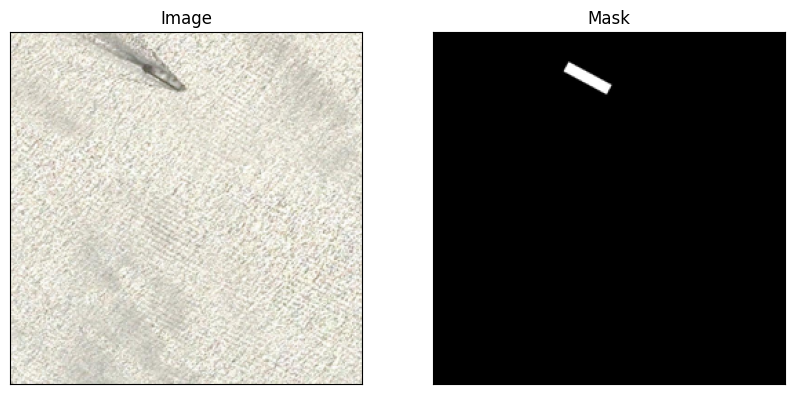

In [32]:
example_image = dataset[3]["image"]
example_mask = dataset[3]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [33]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [34]:

from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [35]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

2024-02-23 13:33:30.584637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 13:33:30.584750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 13:33:30.712269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [36]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

In [38]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [39]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([5, 3, 1024, 1024])
original_sizes torch.Size([5, 2])
reshaped_input_sizes torch.Size([5, 2])
input_boxes torch.Size([5, 1, 4])
ground_truth_mask torch.Size([5, 256, 256])


In [40]:
batch["ground_truth_mask"].shape

torch.Size([5, 256, 256])

In [ ]:
# from transformers import SamModel
# model = SamModel.from_pretrained("facebook/sam-vit-base") #доп

In [ ]:
# import numpy as np #доп
# import random
# import torch
# import matplotlib.pyplot as plt

# idx = 850
# test_image = dataset[idx]["image"]

# # get box prompt based on ground truth segmentation map
# ground_truth_mask = np.array(dataset[idx]["label"])
# prompt = get_bounding_box(ground_truth_mask)

# # prepare image + box prompt for the model
# inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# # Move the input tensor to the GPU if it's not already there
# inputs = {k: v.to(device) for k, v in inputs.items()}

# model.eval()

# # forward pass
# with torch.no_grad():
#     outputs = model(**inputs, multimask_output=False)

# # apply sigmoid
# medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# # convert soft mask to hard mask
# medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
# medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Plot the first image on the left
# axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
# axes[0].set_title("Image")

# # Plot the second image on the right
# axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
# axes[1].set_title("Mask")

# # Plot the second image on the right
# axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
# axes[2].set_title("Probability Map")

# # Hide axis ticks and labels
# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# # Display the images side by side
# plt.show()

In [ ]:
!pip install --upgrade transformers

In [41]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [43]:
pip install monai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [44]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-7, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
# model.load_state_dict(torch.load("/kaggle/working/model_checkpoint.pth"))

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

 20%|█▉        | 397/2000 [10:31<42:30,  1.59s/it]

In [47]:
torch.save(model.state_dict(), "model_checkpoint_5.pth")

from IPython.display import FileLink
FileLink('model_checkpoint_5.pth')

/kaggle/working/model_checkpoint_4.pth

In [48]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [49]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/kaggle/working/model_checkpoint_5.pth"))

<All keys matched successfully>

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

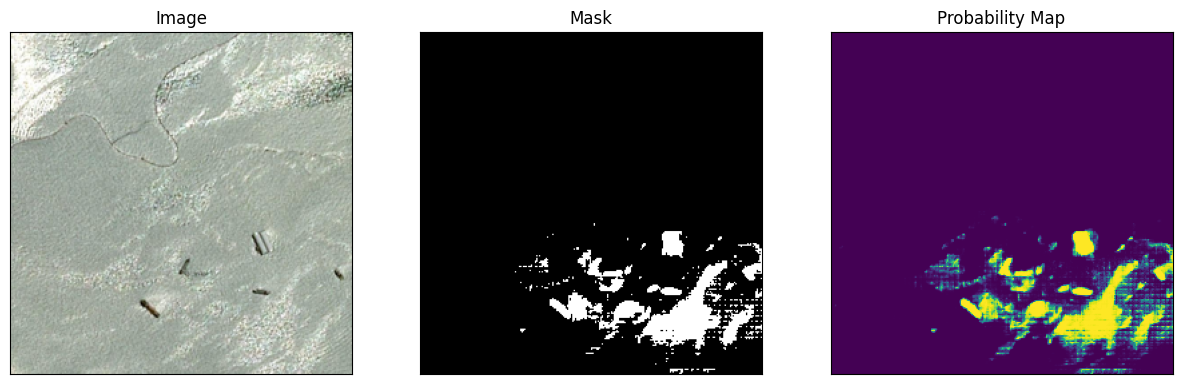

In [74]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

idx = 222
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()